In [1]:
%cd src

/home/romet/projects/ut/automl/src


In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from dataloader import load_data, load_test_data

In [3]:
train = load_data(autofeat_transform=True)
train = train.drop(['ID_code', 'target'], axis=1)
feature_list = list(train.columns)

Reading training data...
Original train shape:  (200000, 202)
Frequency encoding...
shape returned by frequency_encoding function (200000, 200)
[AutoFeat] Computing 106 new features.
[AutoFeat]   106/  106 new features ...done.
shape returned by add_autofeat_features function (200000, 308)
Scaling data...


/home/romet/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
/home/romet/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


target data type is int64
shape returned by load_data function (200000, 508)


## LightGBM feature importance

In [4]:
feat_mean_lgbm = np.zeros(506)
FOLDS = 5
for i in range(FOLDS):
    bst = lgb.Booster(model_file=f'../models/lightgbm-autofeat-{i}.txt')
    fi = bst.feature_importance()
    feat_mean_lgbm += fi
    
feat_mean_lgbm = feat_mean_lgbm / FOLDS

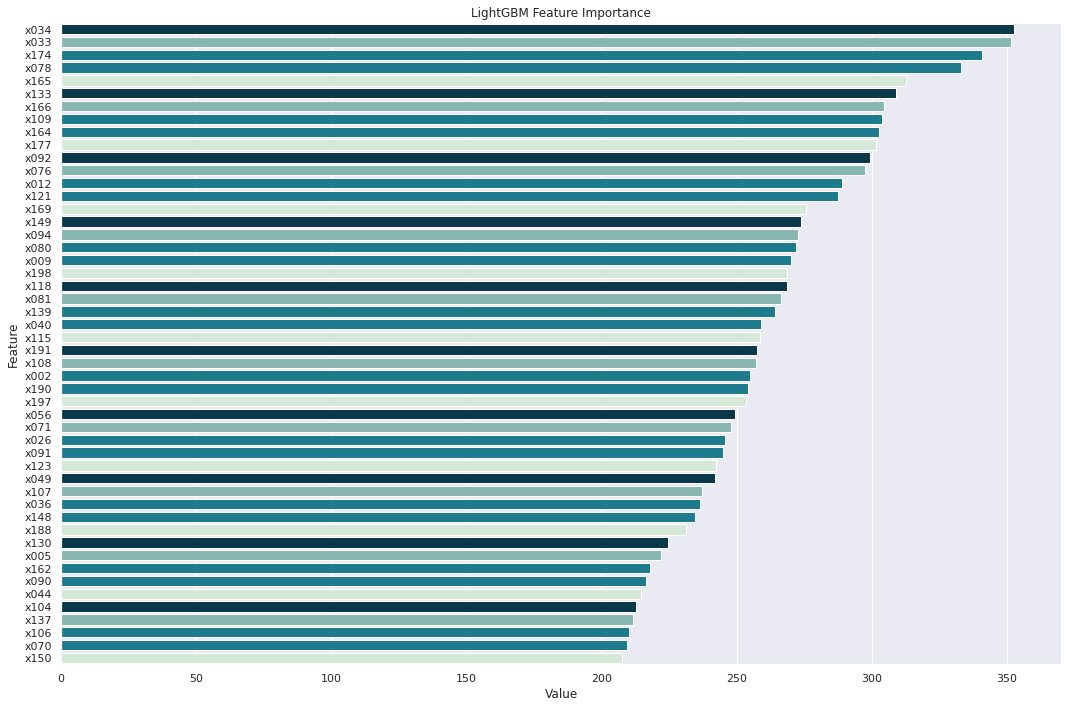

In [5]:
feature_imp = pd.DataFrame(sorted(zip(feat_mean_lgbm,feature_list)), columns=['Value','Feature'])

plt.figure(figsize=(15, 10))

sns.set()
colors = ["#003B55", "#80BFB7", "#0B87A1" , "#0B87A1", "#D3EBD5"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:50], palette=colors)
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

## XGBoost feature importance

In [6]:
feat_mean_xgb = {feature_name:0 for feature_name in feature_list}

FOLDS = 5
for i in range(FOLDS):
    model_xgb_2 = xgb.Booster()
    model_xgb_2.load_model(f"../models/xgb-autofeat-{i}.json")
    model_xgb_2.feature_names = list(feature_list)
    feature_important = model_xgb_2.get_score(importance_type='weight')
    
    for feature_name, importance in feature_important.items():
        feat_mean_xgb[feature_name] = feat_mean_xgb[feature_name] + importance

In [7]:
xgb_feature_imp = pd.DataFrame(sorted(zip(np.array(list(feat_mean_xgb.values())) / FOLDS, feat_mean_xgb.keys())), columns=['Value','Feature'])

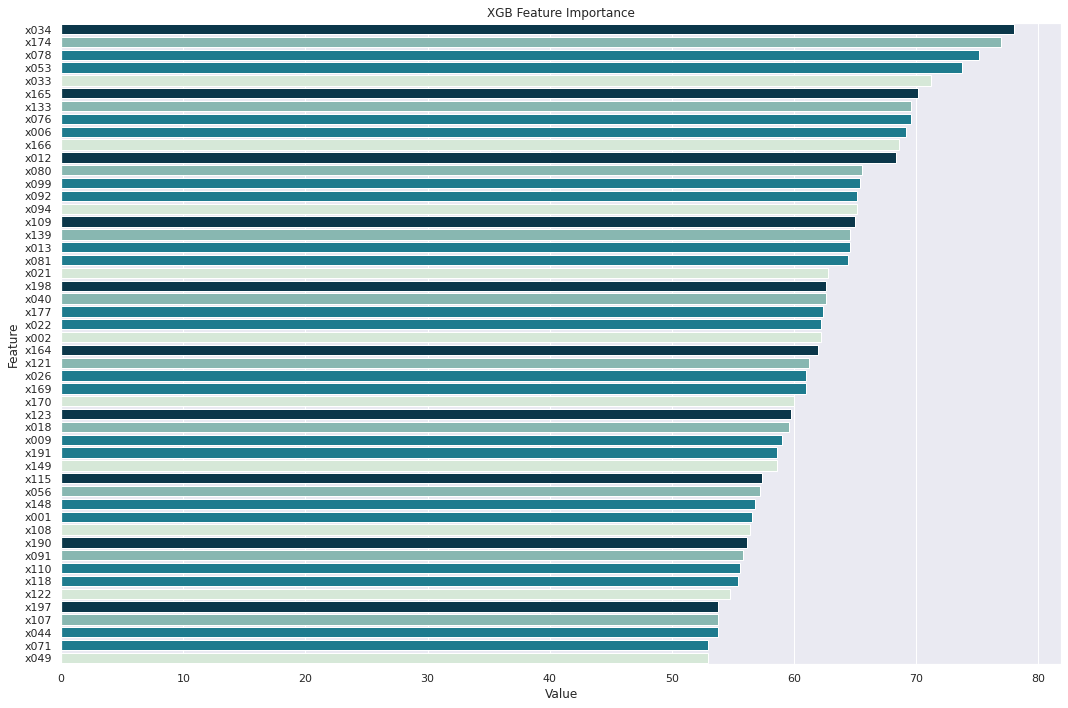

In [8]:
plt.figure(figsize=(15, 10))

sns.set()
colors = ["#003B55", "#80BFB7", "#0B87A1" , "#0B87A1", "#D3EBD5"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sns.barplot(x="Value", y="Feature", data=xgb_feature_imp.sort_values(by="Value", ascending=False)[0:50], palette=colors)
plt.title('XGB Feature Importance')
plt.tight_layout()
plt.show()